In [10]:
from sentinelhub import SHConfig

config = SHConfig()
config.sh_client_id = 'sh-fe080851-d462-4304-9f4d-1b7fd7c7dc95'
config.sh_client_secret = 'XBnxUPfjs1duw9wmexDpoVmhTbY6piHw'
config.sh_base_url = 'https://sh.dataspace.copernicus.eu'
config.sh_token_url = 'https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token'

In [11]:
import datetime
import os
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from rasterio.transform import from_bounds
from pathlib import Path
from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
)


In [12]:
hyd_coords_wgs84 = (78.00405826,16.93264351,79.04971836,17.90150706)
resolution=(500,500)
hyd_bbox = BBox(bbox=hyd_coords_wgs84, crs=CRS.WGS84)
hyd_size = bbox_to_dimensions(hyd_bbox, resolution=resolution)

print(f"Image shape at {resolution} m resolution: {hyd_size} pixels")

Image shape at (500, 500) m resolution: (225, 212) pixels


In [13]:
evalscript_mean_mosaic = """
//VERSION=3
function setup() {
    return {
        input: ["O3", "dataMask"],
        output: {
            bands: 1,
            sampleType: "FLOAT32",
        },
        mosaicking: "ORBIT"
    };
}

function isClear(sample) {
    return sample.dataMask == 1;
}

function sum(array) {
    let sum = 0;
    for (let i = 0; i < array.length; i++) {
        sum += array[i].O3;
    }
    return sum;
}

function evaluatePixel(samples) {
    const clearTs = samples.filter(isClear)
    const mean = sum(clearTs) / clearTs.length
    return [mean]
}
"""

In [14]:
def get_data(time_interval):
    request = SentinelHubRequest(
        evalscript=evalscript_mean_mosaic,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL5P.define_from(
                    "s5pl2", service_url=config.sh_base_url
                ),
                time_interval=time_interval,
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
        bbox=hyd_bbox,
        size=hyd_size,
        config=config,
        data_folder=r"C:\Users\rishi\ml_projects\climate\temp_18\O3",
    )
    raw_data = request.get_data(save_data=True)
    return raw_data[0]

In [15]:
get_data(("2018-12-1", "2018-12-31"))

array([[0.10456945, 0.10453094, 0.10455348, ..., 0.10488391, 0.10496876,
        0.10502136],
       [0.10459895, 0.1046126 , 0.10460005, ..., 0.1049344 , 0.10495017,
        0.10495399],
       [0.10466959, 0.10464293, 0.10463484, ..., 0.10495556, 0.10502034,
        0.10498399],
       ...,
       [0.1047722 , 0.10475767, 0.10468943, ..., 0.10564179, 0.10564779,
        0.10562873],
       [0.10480142, 0.10480031, 0.10477015, ..., 0.10562158, 0.10561444,
        0.10562567],
       [0.10491135, 0.10489731, 0.10490455, ..., 0.10560258, 0.10557643,
        0.10555311]], dtype=float32)

In [16]:
# months = {
#     1: ("January", 31),
#     2: ("February", 28),
#     3: ("March", 31),
#     4: ("April", 30),
#     5: ("May", 31),
#     6: ("June", 30),
#     7: ("July", 31),
#     8: ("August", 31),
#     9: ("September", 30),
#     10: ("October", 31),
#     11: ("November", 30),
#     12: ("December", 31)
# }
# vals=[]
# output_dir=r"C:\Users\rishi\ml_projects\climate\2023_data\O3"
# for i in range(1,13):
#     month_name, end_day = months[i]
#     start=f"2023-{i}-1"
#     end = f"2023-{i}-{end_day}"
#     time_interval=(start,end)
#     arr=get_data(time_interval)
#     path=os.path.join(output_dir, f'{month_name}_O3.csv')
#     np.savetxt(path, arr, delimiter=',')

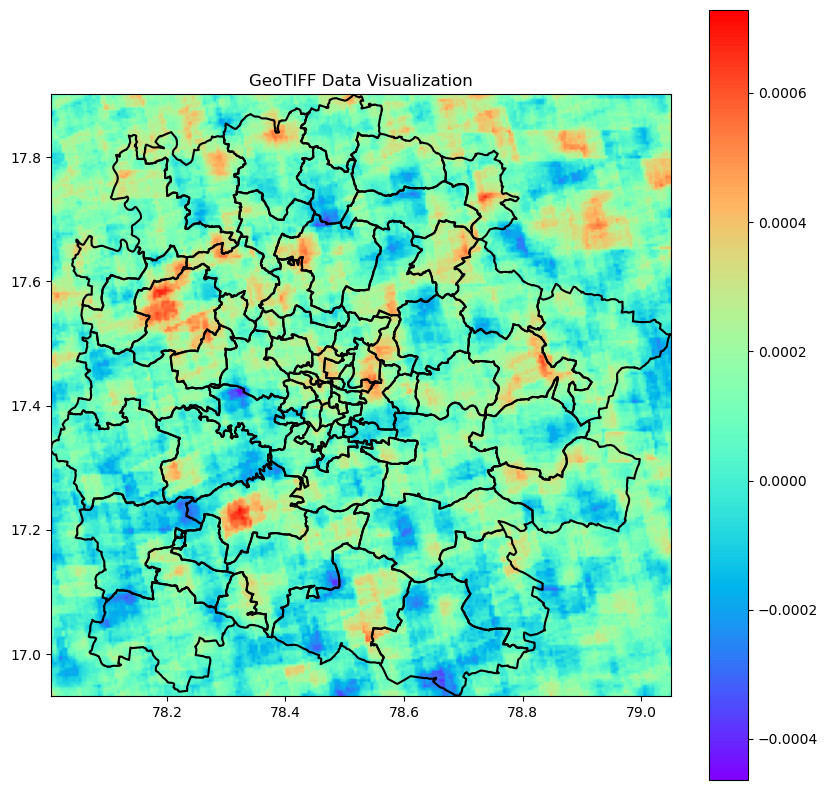

In [28]:
import geopandas as gpd

# Load the shapefile
shapefile_path = r'C:\Users\rishi\ml_projects\climate\hmda_boundary\hmda_boundary.shp'
gdf = gpd.read_file(shapefile_path)

import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
# Load the GeoTIFF file
vmin = .1072  # Minimum value for normalization
vmax = .1086  # Maximum value for normalization

# Open the GeoTIFF file
tiff_file = r'C:\Users\rishi\ml_projects\climate\500_23\SO2\response.tiff'
with rasterio.open(tiff_file) as dataset:
    # Create a normalization instance
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    
    # Display the image with geospatial context
    fig, ax = plt.subplots(figsize=(10, 10))
    show(dataset, ax=ax, cmap='rainbow')
    plt.title('GeoTIFF Data Visualization')
    
    # Add a colorbar with the same normalization
    plt.colorbar(ax.images[0], ax=ax, orientation='vertical')
    
    # Plot the boundary of the GeoDataFrame
    gdf.boundary.plot(ax=ax, edgecolor='black')
    
    plt.show()

In [18]:
with rasterio.open(tiff_file) as dataset:
    # Print metadata
    print(dataset.meta)
    num_bands = dataset.count
    print(f"The GeoTIFF file has {num_bands} band(s).")
    # Get the spatial extent (bounding box)
    print("Bounds:", dataset.bounds)
    
    # Read the data as a numpy array (e.g., first band)
    data = dataset.read(1)
    print("Data shape:", data.shape)
    print(data)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 16, 'height': 30, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0653537562500004, 0.0, 78.00405826,
       0.0, -0.032295451666666725, 17.90150706)}
The GeoTIFF file has 1 band(s).
Bounds: BoundingBox(left=78.00405826, bottom=16.93264351, right=79.04971836, top=17.90150706)
Data shape: (30, 16)
[[3.3865825e-05 3.5554800e-05 3.2124452e-05 3.1095078e-05 3.7677386e-05
  4.2547210e-05 3.9977887e-05 3.8760918e-05 3.4747773e-05 4.0281408e-05
  3.2868687e-05 3.7013688e-05 3.6018726e-05 3.4234512e-05 3.7190468e-05
  3.6448298e-05]
 [3.4537989e-05 3.4360168e-05 3.1935444e-05 3.3498065e-05 3.7768546e-05
  4.1963704e-05 3.9339884e-05 3.9681036e-05 3.6665435e-05 3.7735932e-05
  3.4941040e-05 3.6412621e-05 3.3457207e-05 3.2815471e-05 3.5801957e-05
  3.5837431e-05]
 [3.8368064e-05 3.6097350e-05 3.0943847e-05 3.3885641e-05 3.7451977e-05
  3.9407281e-05 4.1696323e-05 3.6041543e-05 3.5976635e-05 3.3903227e-05
  3.7642014e-